In [1]:
!pip install visualkeras seaborn

In [2]:
import os

DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [4]:
import h5py

In [5]:
tf.keras.backend.clear_session()

In [6]:
train_path = '../data/Coivd-19_Synthetic/GANGEN_2022-6-30-05-53_v5'
test_path = '../data/Covid-19 Image Dataset/test'

In [7]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [8]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

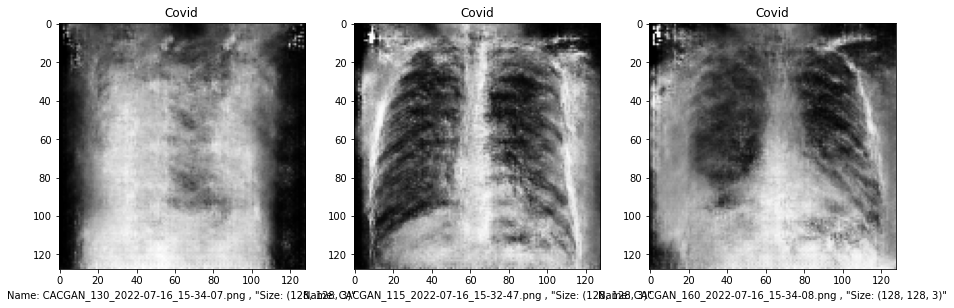

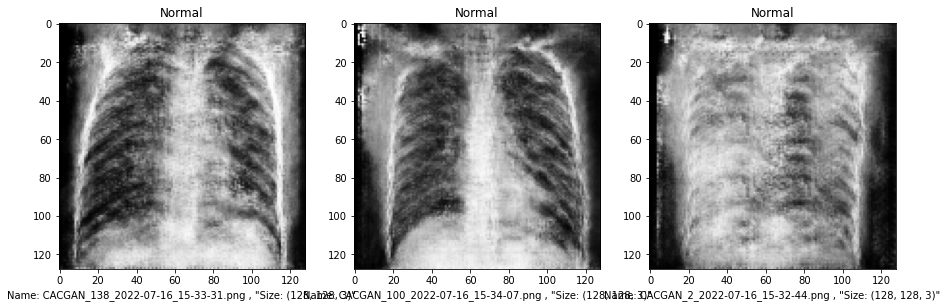

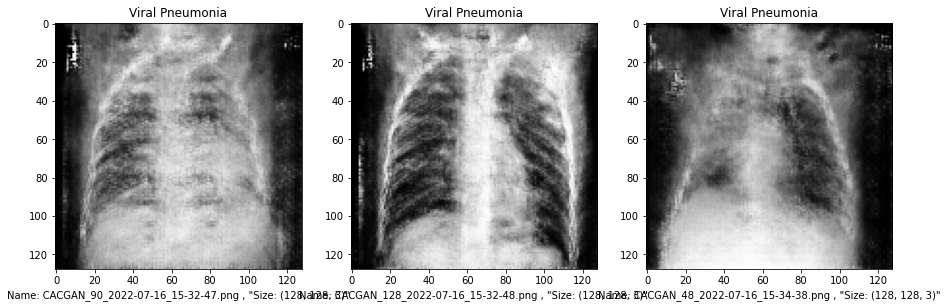

In [9]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [11]:
img_size = 128
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size, img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size, img_size)
                                                    )

Found 2000 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [12]:
model = Sequential()
# model.add(Conv2D(filters=16, input_shape=(img_size*img_size*3, ), kernel_size=(9,9), strides=(5,5), padding='valid'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))
# model.add(BatchNormalization())

# # Passing it to a dense layer
# model.add(Flatten())
model.add(Flatten(input_shape = (img_size, img_size, 3)))
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.4)) # 2022年6月30日06点07分 avoid underfitting
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(Dropout(0.45)) # 2022年6月30日06点07分 avoid underfitting
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.2)) # 2022年6月30日06点07分 avoid underfitting
model.add(Dense(32))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.2)) # 2022年6月30日06点07分 avoid underfitting
model.add(BatchNormalization())
#  output Layer 
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

In [13]:
# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [14]:
!pip install pydot

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0

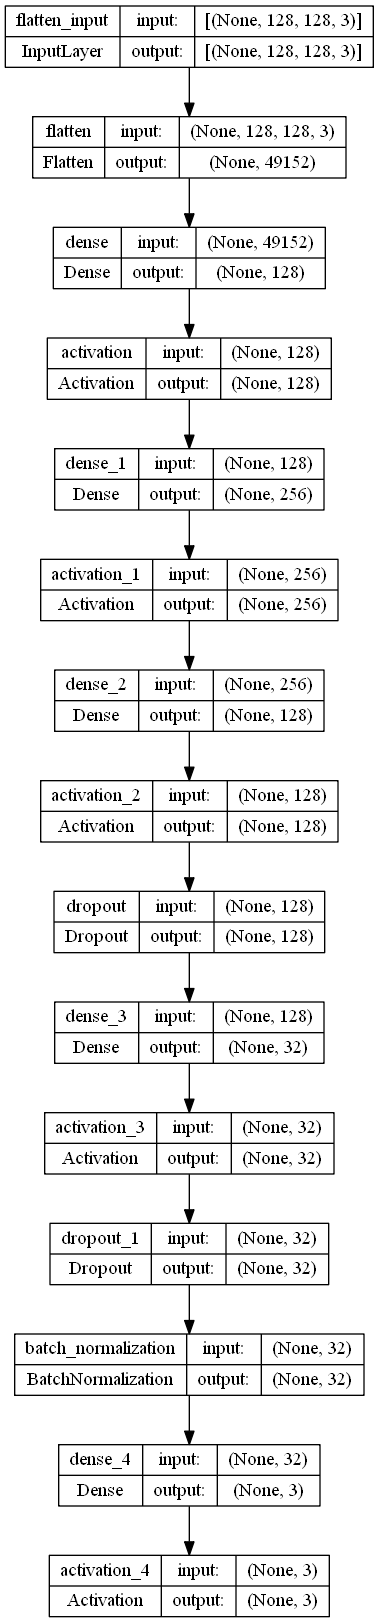

In [16]:
plot_model(model, to_file='../images/mlp_model.png', show_shapes=True, show_layer_names=True)

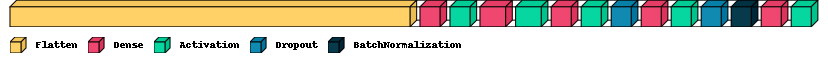

In [17]:
visualkeras.layered_view(model, legend=True)

In [18]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1), 
#              ModelCheckpoint('../models/mlp_model_cacgan.h5', save_best_only=True)]
callbacks = [EarlyStopping(monitor='val_accuracy', patience=100, verbose=1), 
             ModelCheckpoint('../models/mlp_model.h5', save_best_only=True)] # for future training 2022年6月30日06点35分

In [19]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
!pip install h5py

In [21]:
history = model.fit(train_generator,
                    epochs=320,
                    validation_data=test_generator,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/320
125/125 [==============================] - 9s 62ms/step - loss: 1.2721 - accuracy: 0.4260 - val_loss: 1.0377 - val_accuracy: 0.6364
Epoch 2/320
125/125 [==============================] - 8s 66ms/step - loss: 0.9589 - accuracy: 0.5800 - val_loss: 0.9222 - val_accuracy: 0.4848
Epoch 3/320
125/125 [==============================] - 8s 63ms/step - loss: 0.8569 - accuracy: 0.6165 - val_loss: 0.8562 - val_accuracy: 0.6212
Epoch 4/320
125/125 [==============================] - 9s 70ms/step - loss: 0.8473 - accuracy: 0.6260 - val_loss: 0.8002 - val_accuracy: 0.6515
Epoch 5/320
125/125 [==============================] - 8s 62ms/step - loss: 0.8065 - accuracy: 0.6440 - val_loss: 0.7349 - val_accuracy: 0.6061
Epoch 6/320
125/125 [==============================] - 8s 61ms/step - loss: 0.7831 - accuracy: 0.6520 - val_loss: 0.7550 - val_accuracy: 0.6061
Epoch 7/320
125/125 [==============================] - 8s 65ms/step - loss: 0.7999 - accuracy: 0.6365 - val_loss: 0.8362 - val_accuracy:

125/125 [==============================] - 8s 61ms/step - loss: 0.6107 - accuracy: 0.7490 - val_loss: 0.6151 - val_accuracy: 0.6667
Epoch 58/320
125/125 [==============================] - 8s 60ms/step - loss: 0.5959 - accuracy: 0.7510 - val_loss: 0.6349 - val_accuracy: 0.6818
Epoch 59/320
125/125 [==============================] - 8s 62ms/step - loss: 0.5993 - accuracy: 0.7605 - val_loss: 0.6239 - val_accuracy: 0.6970
Epoch 60/320
125/125 [==============================] - 8s 61ms/step - loss: 0.6295 - accuracy: 0.7435 - val_loss: 0.6662 - val_accuracy: 0.6364
Epoch 61/320
125/125 [==============================] - 8s 67ms/step - loss: 0.5880 - accuracy: 0.7690 - val_loss: 0.5715 - val_accuracy: 0.7121
Epoch 62/320
125/125 [==============================] - 8s 61ms/step - loss: 0.6049 - accuracy: 0.7580 - val_loss: 0.6250 - val_accuracy: 0.6364
Epoch 63/320
125/125 [==============================] - 8s 63ms/step - loss: 0.6105 - accuracy: 0.7425 - val_loss: 1.6185 - val_accuracy: 0.636

125/125 [==============================] - 8s 65ms/step - loss: 0.5817 - accuracy: 0.7620 - val_loss: 0.9575 - val_accuracy: 0.6061
Epoch 114/320
125/125 [==============================] - 8s 64ms/step - loss: 0.5841 - accuracy: 0.7660 - val_loss: 0.8277 - val_accuracy: 0.6364
Epoch 115/320
125/125 [==============================] - 8s 62ms/step - loss: 0.5871 - accuracy: 0.7540 - val_loss: 0.6107 - val_accuracy: 0.6818
Epoch 116/320
125/125 [==============================] - 8s 61ms/step - loss: 0.5575 - accuracy: 0.7730 - val_loss: 0.7039 - val_accuracy: 0.6515
Epoch 117/320
125/125 [==============================] - 8s 61ms/step - loss: 0.5772 - accuracy: 0.7775 - val_loss: 0.7893 - val_accuracy: 0.6364
Epoch 118/320
125/125 [==============================] - 8s 61ms/step - loss: 0.5830 - accuracy: 0.7690 - val_loss: 0.6889 - val_accuracy: 0.6515
Epoch 119/320
125/125 [==============================] - 8s 62ms/step - loss: 0.5708 - accuracy: 0.7620 - val_loss: 0.6363 - val_accuracy:

125/125 [==============================] - 7s 52ms/step - loss: 0.5403 - accuracy: 0.7885 - val_loss: 0.5967 - val_accuracy: 0.7121
Epoch 170/320
125/125 [==============================] - 7s 52ms/step - loss: 0.5210 - accuracy: 0.7960 - val_loss: 0.6772 - val_accuracy: 0.6818
Epoch 171/320
125/125 [==============================] - 7s 54ms/step - loss: 0.5358 - accuracy: 0.7880 - val_loss: 0.5767 - val_accuracy: 0.6818
Epoch 172/320
125/125 [==============================] - 7s 52ms/step - loss: 0.5390 - accuracy: 0.7745 - val_loss: 0.5074 - val_accuracy: 0.7273
Epoch 173/320
125/125 [==============================] - 7s 53ms/step - loss: 0.5146 - accuracy: 0.8010 - val_loss: 0.7290 - val_accuracy: 0.6667
Epoch 174/320
125/125 [==============================] - 7s 52ms/step - loss: 0.5356 - accuracy: 0.7865 - val_loss: 0.6929 - val_accuracy: 0.6818
Epoch 175/320
125/125 [==============================] - 7s 54ms/step - loss: 0.5249 - accuracy: 0.7790 - val_loss: 0.4922 - val_accuracy:

125/125 [==============================] - 8s 63ms/step - loss: 0.5087 - accuracy: 0.7865 - val_loss: 0.6588 - val_accuracy: 0.6970
Epoch 225: early stopping


In [22]:
model = load_model('../models/mlp_model.h5')

In [23]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

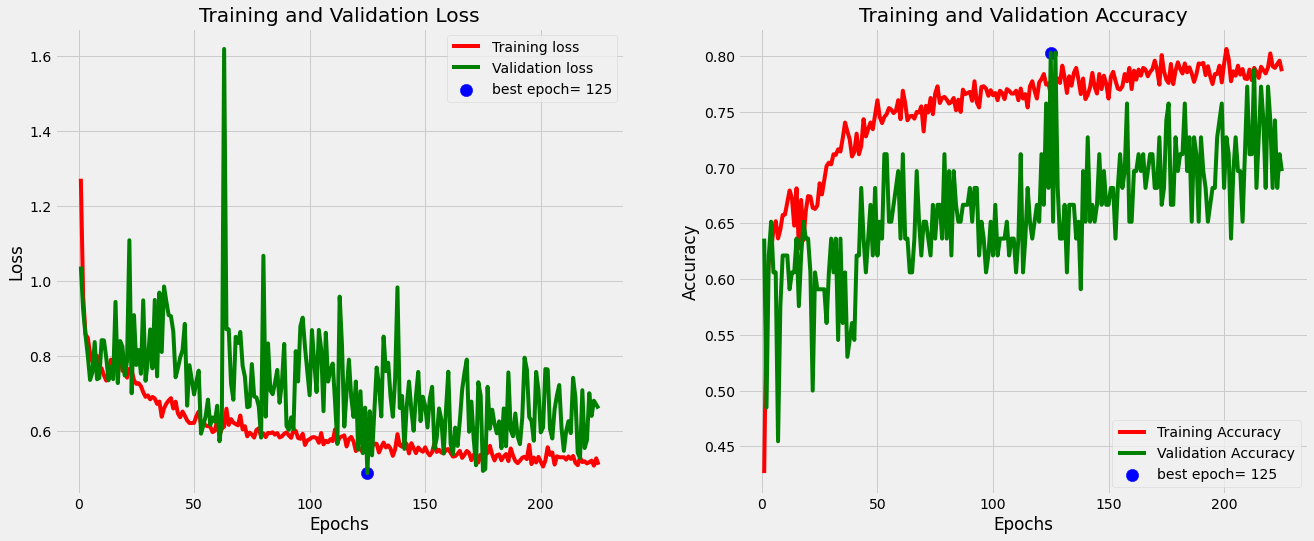

In [24]:
tr_plot(history, 0)

In [25]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 1s 16ms/step - loss: 0.4864 - accuracy: 0.8030
Loss: 48.642
Accuracy: 80.303


In [26]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

66/66 [==============================] - 1s 16ms/step


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [27]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [28]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('../images/con_mat_cacgan.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [29]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [30]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[24  0  1]
 [ 2 12  2]
 [ 0  8 17]]


F1 Score: 0.8043176866706278


                 precision    recall  f1-score   support

          Covid       0.92      0.96      0.94        25
         Normal       0.60      0.75      0.67        16
Viral Pneumonia       0.85      0.68      0.76        25

       accuracy                           0.80        66
      macro avg       0.79      0.80      0.79        66
   weighted avg       0.82      0.80      0.80        66



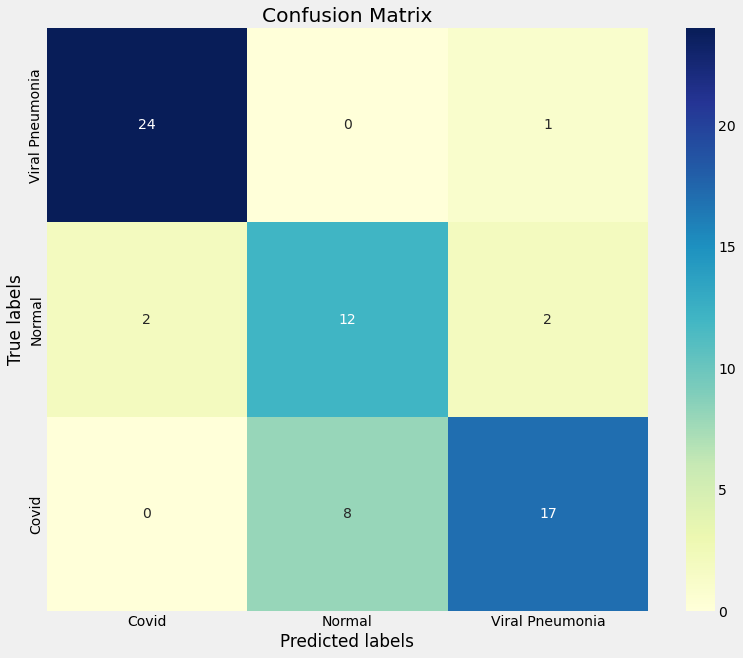

In [31]:
cal_score(model, plot=True)